In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 + 4*x + 5

In [3]:
f(3.0)

44.0

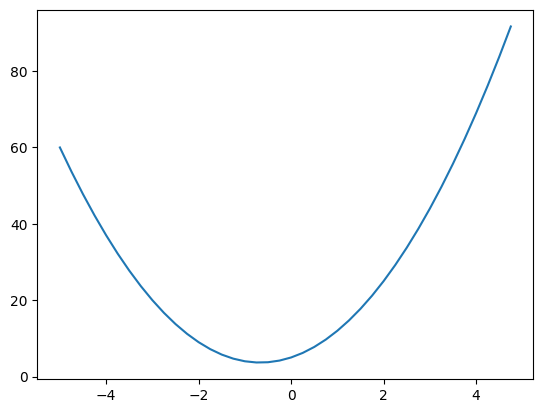

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys
plt.plot(xs, ys)

In [5]:
f(3.0)

44.0

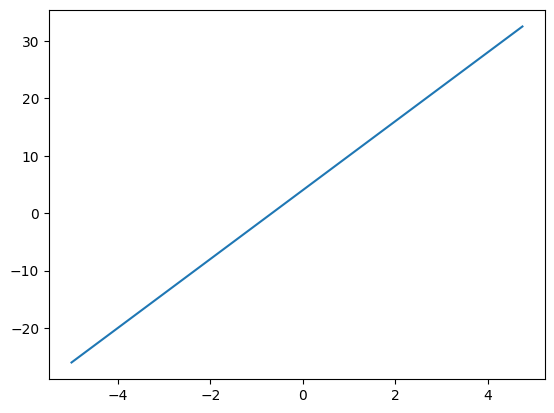

In [6]:
h = 0.000001
x = 3.0
def f_prime(x):
    return (f(x+h) - f(x)) / h

xs = np.arange(-5, 5, 0.25)
ys = f_prime(xs)
plt.plot(xs, ys)

## Backpropagation in a nutshell.

A neural network is a graph composed of differentiable n-ary operators

Backpropagation is computing the gradient wrt some root node for each updatable descendant node in the graph.

Given a set of weights, an input and a loss function
- For each node (aka f), for each n input weights to the operator (aka a, b, for binary operator), define local derivatives (aka df/da, df/db)
- Starting from the root node (aka the evaluation of the loss function on the input), use the chain rule to define the global derivative (aka dL/da, dL/db)
  - The outermost operator's local derivative is a global derivative (aka dL/df)
  - For a node f
    - The global derivative of an inputs of f (aka dL/da) is the sum of all the local derivatives to f (aka df/da) multiplied by the the global derivative of f (aka dL/df)
    - The sum is important. If the same input appears twice in e.g. binary operator, we need to consider its effect in both positions.


In [7]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
        


a = Value(3.0, label='a')
b = Value(4.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = c + e; f.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-44.0)

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

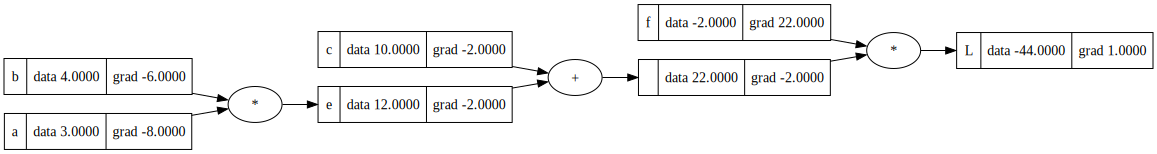

In [9]:
L.backward()
draw_dot(L)

In [10]:
import torch

In [11]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [12]:
torch.Tensor([2.0]).double()

tensor([2.], dtype=torch.float64)

## How does a neuron work?
A neuron takes an n-dimensional input and smashes it into a single output
1. Multiply each input by a corresponding weight
2. Sum it
3. Pipe it through an activation function

Dimensionality: (n)


## How do the neurons compose into layer?
A layer is composed of multiple neurons. They each take the n-dimensional input but may each return different 1 dimensional outputs bc they might have different weights.
The result of a layer with m neurons is a function that takes n-dimensional input and a m dimensional output.

Dimensionality: (n, m)

## How do layers compose into a multi-layer perceptron?

An MLP has multiple layers. Each layer take the outputs of the last layer as input.
What this means is that the input dimensions of each layer need to match the output dimensions of the last layer.

Dimensionality: (n, m1, m2, m3, ...)

Each layer has the following dimensions:
Layer 1: (n, m1)
Layer 2: (m1, m2)
Layer 3: (m2, m3)
...






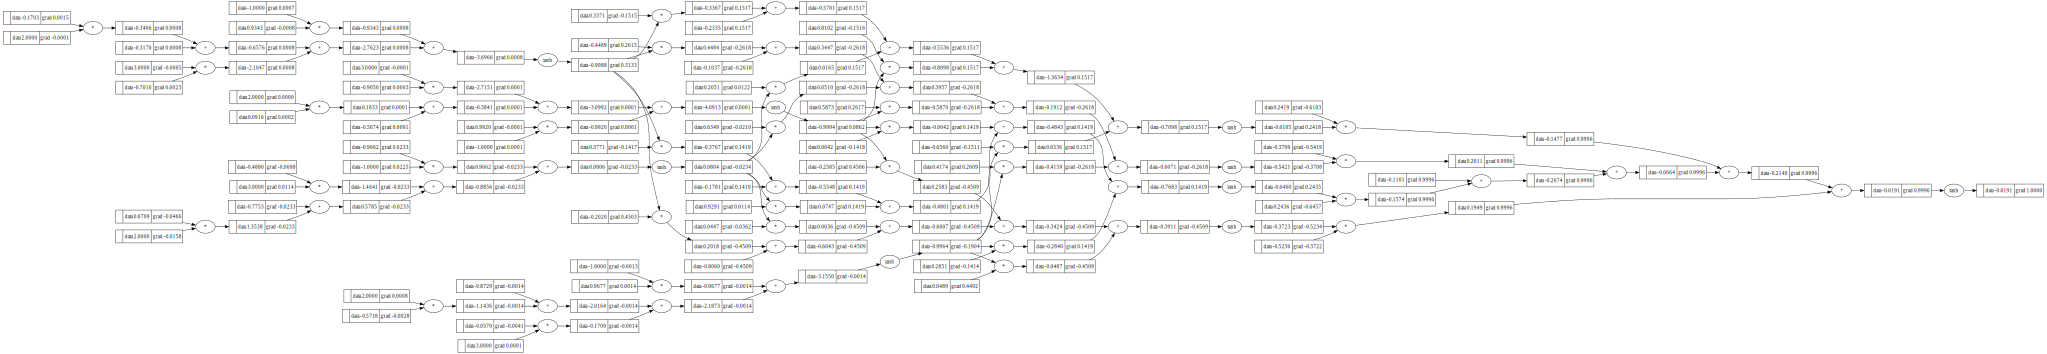

In [13]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act =  sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        if len(out) == 1:
            return out[0]
        return out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, n_ins, n_outs):
        sz = [n_ins] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
L = n(x)
L.backward()
draw_dot(L)

In [14]:
len(n.parameters())

41

In [15]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.515604150731657)

In [16]:
loss.backward()
n.layers[0].neurons[0].w[0].data

-0.1702976381230228

In [17]:
n.layers[0].neurons[0].w[0].grad

1.9237716841142087

In [18]:
for k in range(20):
    # Forward pass

    ## Get predictions
    ypred = [n(x) for x in xs]

    ## Compute loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Backward pass

    ## Zero gradients
    for p in n.parameters():
        p.grad = 0.0
    
    ## Compute gradients
    loss.backward()

    # Update parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.515604150731657
1 3.9963760433949918
2 3.267227840348159
3 2.891484732197864
4 2.608094011462816
5 2.2969544423041195
6 1.8648730034067902
7 1.2887990617028073
8 0.7840231943432849
9 0.4996716862063167
10 0.3511500647823386
11 0.2660316642615898
12 0.21230455044313865
13 0.17575192290036956
14 0.14944143792462905
15 0.12967210716004235
16 0.11431256259392904
17 0.10205719454022694
18 0.09206487357904072
19 0.08377070679966526


In [19]:
ypred

[Value(data=0.8625293878217082),
 Value(data=-0.8488783250252057),
 Value(data=-0.8509700460964797),
 Value(data=0.8591992550470056)]